In [108]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import logical_not
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from custom_transform import *
from model import MNISTNet
from transforms import TRANSFORMS
from mask import *
import imageio
from utils import generate_gif
import os


def load_model(filepath, device):
    model = MNISTNet().to(device)
    model.load_state_dict(torch.load(filepath))
    model.eval()
    return model

In [109]:
device = torch.device("cpu")
model = load_model("./mnist_cnn.pt", device)


test_data = datasets.MNIST('./data', train=False, download=False, transform=TRANSFORMS['Original'])



# Transform tool
img_eraser = CustomizeMask(value=0)
# For tracking the unmasked rectangle in the image when do the transform that after cutting the image, it is
# still a rectangle


threshold = 0.6


In [110]:
def delta_debugging_with_cut_in_rectangle(img_eraser, model, threshold, img, label):

    c, h, w = img.shape

    current_unmasked_pixels = torch.ones((c, h, w))
    
    keep_going = True
    smaller_chunk = False

    current_img = img.clone()
    current_pred = None
    current_pred_prob = 1

    prev_img = img.clone()
    prev_pred = None
    prev_pred_prob = 1
    
    current_unmask_i, current_unmask_j, current_unmask_h, current_unmask_w = 0, 0, h, w
    
    while keep_going and not smaller_chunk:
        print("binary ongoing")
        first_half_unmask, first_i, first_j, first_h, first_w, second_half_unmask, second_i, second_j, second_h, second_w = rectangle_half(
            current_unmasked_pixels,
            current_unmask_i,
            current_unmask_j,
            current_unmask_h,
            current_unmask_w)
        first_img = img_eraser(img, first_half_unmask)
        second_img = img_eraser(img, second_half_unmask)
        first_extend_img = first_img[None, :]
        second_extend_img = second_img[None, :]

        with torch.no_grad():
            first_output = model(first_extend_img)
            second_output = model(second_extend_img)
        first_pred_prob = torch.max(torch.exp(first_output)).item()
        first_pred = torch.argmax(first_output).item()
        second_pred_prob = torch.max(torch.exp(second_output)).item()
        second_pred = torch.argmax(second_output).item()

        prev_img, prev_pred, prev_pred_prob = current_img, current_pred, current_pred_prob
        figure = plt.figure()
        plt.imshow(prev_img.reshape(28, 28), cmap="gray")
        
        # Both done correct prediction
        if first_pred == second_pred and first_pred == label:
            if first_pred_prob >= second_pred_prob and first_pred_prob >= threshold:
                current_unmasked_pixels = first_half_unmask
                current_unmask_i, current_unmask_j, current_unmask_h, current_unmask_w = first_i, first_j, first_h, first_w
                current_img, current_pred, current_pred_prob = first_img, first_pred, first_pred_prob
            elif second_pred_prob >= threshold:
                current_unmasked_pixels = second_half_unmask
                current_unmask_i, current_unmask_j, current_unmask_h, current_unmask_w = second_i, second_j, second_h, second_w
                current_img, current_pred, current_pred_prob = second_img, second_pred, second_pred_prob
        # One of them done correct prediction
        elif first_pred == label and first_pred_prob >= threshold:
            current_unmasked_pixels = first_half_unmask
            current_unmask_i, current_unmask_j, current_unmask_h, current_unmask_w = first_i, first_j, first_h, first_w
            current_img, current_pred, current_pred_prob = first_img, first_pred, first_pred_prob
        elif second_pred == label and second_pred_prob >= threshold:
            current_unmasked_pixels = second_half_unmask
            current_unmask_i, current_unmask_j, current_unmask_h, current_unmask_w = second_i, second_j, second_h, second_w
            current_img, current_pred, current_pred_prob = second_img, second_pred, second_pred_prob

        # Both predict wrong
        else:
            smaller_chunk = True

#         if current_pred_prob < threshold:
#             keep_going = False
            
    smaller_group_number = None    
    if smaller_chunk:
        smaller_group_number = 3
        while keep_going:
            print("ongoing:", smaller_group_number)
            prev_img, prev_pred, prev_pred_prob = current_img, current_pred, current_pred_prob
            figure = plt.figure()
            plt.imshow(prev_img.reshape(28, 28), cmap="gray")
            
            pixel_left = int(torch.sum(current_unmasked_pixels).item())
            if smaller_group_number > pixel_left:
                smaller_group_number = pixel_left

            
            try:
                all_new_masks = split_in_smaller_groups(current_unmasked_pixels, smaller_group_number)
            except:
                print("hereeeee")
                keep_going = False
                continue
                
            best_group_num = None
            best_pred_prob = 0
            for m_idx in range(smaller_group_number):
                new_unmask = all_new_masks[m_idx]
                new_img = img_eraser(img, new_unmask)
                new_extend_img = new_img[None, :]
                with torch.no_grad():
                    output = model(new_extend_img)
                new_pred_prob = torch.max(torch.exp(output)).item()
                new_pred = torch.argmax(output).item()
                if new_pred_prob > threshold and new_pred == label and new_pred_prob > best_pred_prob:
                    current_unmasked_pixels = new_unmask
                    current_img, current_pred, current_pred_prob = new_img, new_pred, new_pred_prob
                    best_group_num = m_idx

            if best_group_num is None:
                if smaller_group_number == pixel_left:
                    keep_going = False
                else:
                    smaller_group_number += 1
                
    print("in the end:", smaller_group_number)
    return prev_img , prev_pred, prev_pred_prob




def delta_debugging_general(img_eraser, model, transform_method, threshold, img, label):

    c, h, w = img.shape

    current_unmasked_pixels = torch.ones((c, h, w))
    
    keep_going = True
    smaller_chunk = False

    current_img = img.clone()
    current_pred = None
    current_pred_prob = 1

    prev_img = img.clone()
    prev_pred = None
    prev_pred_prob = 1
    
    
    
#     while keep_going and not smaller_chunk:
#         print("Doing binary search.")
#         first_half_unmask, second_half_unmask = transform_method(current_unmasked_pixels, 0.1)
#         first_img = img_eraser(img, first_half_unmask)
#         second_img = img_eraser(img, second_half_unmask)
#         first_extend_img = first_img[None, :]
#         second_extend_img = second_img[None, :]

#         with torch.no_grad():
#             first_output = model(first_extend_img)
#             second_output = model(second_extend_img)
#         first_pred_prob = torch.max(torch.exp(first_output)).item()
#         first_pred = torch.argmax(first_output).item()
#         second_pred_prob = torch.max(torch.exp(second_output)).item()
#         second_pred = torch.argmax(second_output).item()

# #         print("probabilties:", first_pred_prob, second_pred_prob)

#         prev_img, prev_pred, prev_pred_prob = current_img, current_pred, current_pred_prob
#         figure = plt.figure()
#         plt.imshow(prev_img.reshape(28, 28), cmap="gray")

#         # Both done correct prediction
#         if first_pred == second_pred and first_pred == label :
#             if first_pred_prob >= second_pred_prob and first_pred_prob >= threshold:
#                 current_unmasked_pixels = first_half_unmask
#                 current_img, current_pred, current_pred_prob = first_img, first_pred, first_pred_prob
#             elif second_pred_prob >= threshold:
#                 current_unmasked_pixels = second_half_unmask
#                 current_img, current_pred, current_pred_prob = second_img, second_pred, second_pred_prob
#         # One of them done correct prediction
#         elif first_pred == label and first_pred_prob >= threshold:
#             current_unmasked_pixels = first_half_unmask
#             current_img, current_pred, current_pred_prob = first_img, first_pred, first_pred_prob
#         elif second_pred == label and second_pred_prob >= threshold:
#             current_unmasked_pixels = second_half_unmask
#             current_img, current_pred, current_pred_prob = second_img, second_pred, second_pred_prob

#         # Both predict wrong
#         else:
#             smaller_chunk = True

#         if current_pred_prob < threshold:
#             keep_going = False


    smaller_group_number = None    
    if smaller_chunk:
        smaller_group_number = 3
        while keep_going:
            prev_img, prev_pred, prev_pred_prob = current_img, current_pred, current_pred_prob
            figure = plt.figure()
            plt.imshow(prev_img.reshape(28, 28), cmap="gray")

            pixel_left = int(torch.sum(current_unmasked_pixels).item())
            if smaller_group_number > pixel_left:
                smaller_group_number = pixel_left
            
            try:
                all_new_masks = split_in_smaller_groups(current_unmasked_pixels, smaller_group_number)
            except:
                keep_going = False
                continue
                
            best_group_num = None
            best_pred_prob = 0
            for m_idx in range(smaller_group_number):
                new_unmask = all_new_masks[m_idx]
                new_img = img_eraser(img, new_unmask)
                new_extend_img = new_img[None, :]
                with torch.no_grad():
                    output = model(new_extend_img)
                new_pred_prob = torch.max(torch.exp(output)).item()
                new_pred = torch.argmax(output).item()
                if new_pred_prob > threshold and new_pred == label and new_pred_prob > best_pred_prob:
                    current_unmasked_pixels = new_unmask
                    current_img, current_pred, current_pred_prob = new_img, new_pred, new_pred_prob
                    best_group_num = m_idx

            if best_group_num is None:
                if smaller_group_number == pixel_left:
                    keep_going = False
                else:
                    smaller_group_number += 1
                
    print("in the end:", smaller_group_number)
    return prev_img , prev_pred, prev_pred_prob


In [111]:
# def generate_gif(filename, image_names):

#     with imageio.get_writer(filename, mode='I') as writer:
#         for imgname in image_names:
#             image = imageio.imread(imgname)
#             writer.append_data(image)

In [112]:
def delta_debugging_general_new(img_eraser, model, threshold, img, label):

    c, h, w = img.shape

    current_unmasked_pixels = torch.ones((c, h, w))
    
    keep_going = True
    smaller_chunk = True

    current_img = img.clone()
    current_pred = None
    current_pred_prob = 1

    prev_img = img.clone()
    prev_pred = None
    prev_pred_prob = 1
    
    
    
#     while keep_going and not smaller_chunk:
#         print("Doing binary search.")
#         first_half_unmask, second_half_unmask = transform_method(current_unmasked_pixels, 0.1)
#         first_img = img_eraser(img, first_half_unmask)
#         second_img = img_eraser(img, second_half_unmask)
#         first_extend_img = first_img[None, :]
#         second_extend_img = second_img[None, :]

#         with torch.no_grad():
#             first_output = model(first_extend_img)
#             second_output = model(second_extend_img)
#         first_pred_prob = torch.max(torch.exp(first_output)).item()
#         first_pred = torch.argmax(first_output).item()
#         second_pred_prob = torch.max(torch.exp(second_output)).item()
#         second_pred = torch.argmax(second_output).item()

# #         print("probabilties:", first_pred_prob, second_pred_prob)

#         prev_img, prev_pred, prev_pred_prob = current_img, current_pred, current_pred_prob
#         figure = plt.figure()
#         plt.imshow(prev_img.reshape(28, 28), cmap="gray")

#         # Both done correct prediction
#         if first_pred == second_pred and first_pred == label :
#             if first_pred_prob >= second_pred_prob and first_pred_prob >= threshold:
#                 current_unmasked_pixels = first_half_unmask
#                 current_img, current_pred, current_pred_prob = first_img, first_pred, first_pred_prob
#             elif second_pred_prob >= threshold:
#                 current_unmasked_pixels = second_half_unmask
#                 current_img, current_pred, current_pred_prob = second_img, second_pred, second_pred_prob
#         # One of them done correct prediction
#         elif first_pred == label and first_pred_prob >= threshold:
#             current_unmasked_pixels = first_half_unmask
#             current_img, current_pred, current_pred_prob = first_img, first_pred, first_pred_prob
#         elif second_pred == label and second_pred_prob >= threshold:
#             current_unmasked_pixels = second_half_unmask
#             current_img, current_pred, current_pred_prob = second_img, second_pred, second_pred_prob

#         # Both predict wrong
#         else:
#             smaller_chunk = True

#         if current_pred_prob < threshold:
#             keep_going = False


    img_counter = 0
    img_names = []
    smaller_group_number = None  
    img_folder = "./gif_img"
    if not os.path.exists(img_folder):
        os.mkdir(img_folder)
    if smaller_chunk:
        smaller_group_number = 2
        while keep_going:
            prev_img, prev_pred, prev_pred_prob = current_img, current_pred, current_pred_prob
            
            # save figures for gif
            
            figure = plt.figure()
            plt.title("Pred prob: {}".format(prev_pred_prob))
            plt.imshow(prev_img.reshape(28, 28), cmap="gray")
            img_name = '{}.png'.format(img_counter)
            plt.savefig(os.path.join(img_folder, img_name))
            plt.close(figure)
            img_names.append(img_name)
            img_counter += 1

            pixel_left = int(torch.sum(current_unmasked_pixels).item())
            if smaller_group_number > pixel_left:
                smaller_group_number = pixel_left
            
            try:
                all_new_masks = split_in_smaller_groups(current_unmasked_pixels, smaller_group_number)
            except:
                keep_going = False
                continue
                
            best_group_num = None
            best_pred_prob = 0
            for m_idx in range(smaller_group_number):
                new_unmask = all_new_masks[m_idx]
                new_img = img_eraser(img, new_unmask)
                new_extend_img = new_img[None, :]
                with torch.no_grad():
                    output = model(new_extend_img)
                new_pred_prob = torch.max(torch.exp(output)).item()
                new_pred = torch.argmax(output).item()
                if new_pred_prob > threshold and new_pred == label and new_pred_prob > best_pred_prob:
                    current_unmasked_pixels = new_unmask
                    current_img, current_pred, current_pred_prob = new_img, new_pred, new_pred_prob
                    best_group_num = m_idx

            if best_group_num is None:
                if smaller_group_number == pixel_left:
                    keep_going = False
                else:
                    smaller_group_number += 1
                
    print("in the end:", smaller_group_number)
    generate_gif("./result_samples/{}/gif_results/img_{}.gif".format(label, img_idx), img_folder, img_names, True)
    return prev_img , prev_pred, prev_pred_prob

In [113]:
# for i in range(10):
#     os.mkdir("./result_samples/{}/".format(i))
#     os.mkdir("./result_samples/{}/{}".format(i,'gif_results'))
#     os.mkdir("./result_samples/{}/{}".format(i,'img_results'))

in the end: 34
in the end: 31
in the end: 32


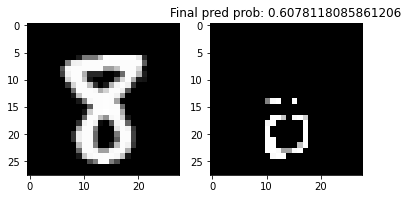

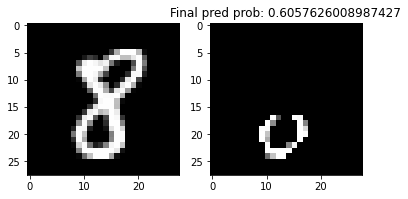

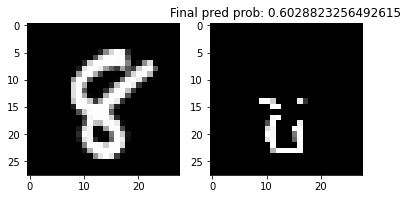

In [119]:

for img_idx in range(120, 150):
    (img, label) = torch.utils.data.Subset(test_data, [img_idx])[0]
    if label != 8:
        continue
#     plt.figure()
#     plt.imshow(img.reshape(28, 28), cmap="gray")

    pred_img, pred_class, pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label)
#     plt.figure()
#     plt.imshow(pred_img.reshape(28, 28), cmap="gray")

    figure = plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img.reshape(28, 28), cmap="gray")
    axarr[1].imshow(pred_img.reshape(28, 28), cmap="gray")
    plt.title("Final pred prob: {}".format(pred_prob))
    plt.savefig("./result_samples/{}/img_results/img_{}.png".format(label, img_idx))
    plt.close(figure)


In [115]:
# pred_img, pred_class, pred_prob = delta_debugging_general(img_eraser, model, random_portion, 0.9, img, label)
# plt.imshow(pred_img.reshape(28, 28), cmap="gray")

In [116]:
# pred_img, pred_class, pred_prob = delta_debugging_with_cut_in_rectangle(img_eraser, model, 0.55, img, label)
# plt.imshow(pred_img.reshape(28, 28), cmap="gray")